# DNN 模型标签匹配方法

可以用两种思路做重训练模型的标签匹配：

- 样本重合率
- 类心距离

**样本重合率** 的问题是不同标签的样本量不同，这意味着不同标签的敏感性是不同的。如果样本量较高，我们就有较高的置信水平认为该重合率可信；但若样本量较低，这种匹配可能是不置信的。使用 **类心距离** 可以避免这个问题，在整个度量空间中，类心距离不会因标签的不同有所偏倚，是一种更公平的匹配方法。

并不是所有模型的标签都有“类心”。比如对于物品 ITEM，可能只有标签，没有“类心”，这时就只能使用更通用的样本重合率方法。下面我们来开发这两种标签匹配方法。

In [22]:
import os
import collections
import numpy as np
import matplotlib.pyplot as plt

import utils

from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from collections import defaultdict
from typing import Dict, Set, Tuple, List
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

CSV_PATH = './data'

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

## 1. 初次训练与重训练标签

In [2]:
# 将 csv 读入 DataFrame
train_csv_path = os.path.join(CSV_PATH, 'embed_label.csv')
train_df = utils.read_embedding_csv(csv_path=train_csv_path,
                                    ebd_cols=['embeddings'])
len(train_df), len(set(train_df['labels'].tolist()))

(10000, 100)

In [3]:
train_df.head()

,embeddings,labels
0,"[0.024523582309484482, -0.03633105754852295, 0...",19
1,"[-0.002521098591387272, 0.022899063304066658, ...",29
2,"[0.008400454185903072, -0.012612388469278812, ...",0
3,"[-0.004734962247312069, -0.0035224033053964376...",11
4,"[-0.021240245550870895, -0.03918471559882164, ...",1


In [4]:
train_df['embeddings'][0].shape

(1408,)

In [5]:
embeddings = train_df['embeddings'].tolist()

k = 100
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(embeddings)

KMeans(n_clusters=100, random_state=42)

In [6]:
# dir(kmeans)

In [7]:
labels1 = kmeans.labels_
centers1 = kmeans.cluster_centers_

labels1.shape, centers1.shape

((10000,), (100, 1408))

In [8]:
kmeans2 = KMeans(n_clusters=k, random_state=37)
kmeans2.fit(embeddings)

KMeans(n_clusters=100, random_state=37)

In [9]:
labels2 = kmeans2.labels_
centers2 = kmeans2.cluster_centers_

labels2.shape, centers2.shape

((10000,), (100, 1408))

## 2. 样本重合率

In [11]:
def calculate_cluster_similarity(
    old_clusters: Dict[int, Set[int]],
    new_clusters: Dict[int, Set[int]]
) -> Tuple[np.ndarray, List[int], List[int]]:
    """计算新旧聚类之间的相似度矩阵

    :param old_clusters: 旧聚类字典，键为聚类ID，值为样本索引集合
    :param new_clusters: 新聚类字典，键为聚类ID，值为样本索引集合
    :return: 返回元组，包含：
        - 相似度矩阵，形状为 (旧聚类数量, 新聚类数量)
        - 旧聚类ID列表
        - 新聚类ID列表
    """
    old_cluster_ids = list(old_clusters.keys())
    new_cluster_ids = list(new_clusters.keys())

    n_old = len(old_cluster_ids)
    n_new = len(new_cluster_ids)
    similarity_matrix = np.zeros((n_old, n_new))

    for i, old_id in enumerate(old_cluster_ids):
        for j, new_id in enumerate(new_cluster_ids):
            # 计算Jaccard相似度
            intersection = len(old_clusters[old_id] & new_clusters[new_id])
            union = len(old_clusters[old_id] | new_clusters[new_id])
            if union > 0:
                similarity_matrix[i, j] = intersection / union

    return similarity_matrix, old_cluster_ids, new_cluster_ids


def reassign_clusters(
    old_clusters: Dict[int, Set[int]],
    new_clusters: Dict[int, Set[int]]
) -> Dict[int, int]:
    """使用匈牙利算法将新聚类标签匹配到旧聚类标签

    :param old_clusters: 旧聚类字典，键为聚类ID，值为样本索引集合
    :param new_clusters: 新聚类字典，键为聚类ID，值为样本索引集合
    :return: 新聚类ID到旧聚类ID的映射字典
    """
    similarity_matrix, old_cluster_ids, new_cluster_ids = calculate_cluster_similarity(
        old_clusters, new_clusters
    )

    # 将相似度转换为成本（1 - 相似度）
    cost_matrix = 1 - similarity_matrix

    # 使用匈牙利算法找到最优匹配
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # 创建从新聚类ID到旧聚类ID的映射
    mapping = {}
    for i, j in zip(row_ind, col_ind):
        mapping[new_cluster_ids[j]] = old_cluster_ids[i]

    return mapping


def calculate_total_accuracy(
    old_clusters: Dict[int, Set[int]],
    new_clusters: Dict[int, Set[int]],
    mapping: Dict[int, int]
) -> float:
    """计算聚类匹配的总体准确率

    :param old_clusters: 旧聚类字典，键为聚类ID，值为样本索引集合
    :param new_clusters: 新聚类字典，键为聚类ID，值为样本索引集合
    :param mapping: 新聚类ID到旧聚类ID的映射字典
    :return: 总体准确率，范围在0到1之间
    """
    total_matched_uids = 0
    total_uids = 0

    for new_id, old_id in mapping.items():
        matched_uids = old_clusters[old_id] & new_clusters[new_id]
        total_matched_uids += len(matched_uids)
        total_uids += len(old_clusters[old_id])
    
    accuracy = total_matched_uids / total_uids

    return accuracy


def calculate_per_mapping_accuracy(
    old_clusters: Dict[int, Set[int]], 
    new_clusters: Dict[int, Set[int]], 
    mapping: Dict[int, int]
) -> Dict[tuple, float]:
    """计算每个聚类映射对的准确率

    :param old_clusters: 旧聚类字典，键为聚类ID，值为样本索引集合
    :param new_clusters: 新聚类字典，键为聚类ID，值为样本索引集合
    :param mapping: 新聚类ID到旧聚类ID的映射字典
    :return: 返回字典，键为(新聚类ID, 旧聚类ID)元组，值为对应的Jaccard相似度准确率
    """
    per_mapping_accuracy = {}

    for new_id, old_id in mapping.items():
        old_cluster = old_clusters[old_id]
        new_cluster = new_clusters[new_id]

        # 计算交集和并集
        intersection = len(old_cluster & new_cluster)
        union = len(old_cluster | new_cluster)

        # 计算Jaccard相似度作为准确率
        accuracy = intersection / union

        # 存储准确率
        per_mapping_accuracy[(new_id, old_id)] = accuracy
    
    return per_mapping_accuracy


def id_generator(used_id_set: Set[int]):
    """生成未被使用的最小ID"""
    i = 0
    while True:
        while i in used_id_set:
            i += 1
        yield i
        i += 1

In [12]:
old_clusters = collections.defaultdict(set)
new_clusters = collections.defaultdict(set)
for i, (old_id, new_id) in enumerate(zip(labels1, labels2)):
    old_clusters[old_id].add(i)
    new_clusters[new_id].add(i)

In [13]:
mapping = reassign_clusters(old_clusters, new_clusters)
total_accuracy = calculate_total_accuracy(old_clusters, new_clusters, mapping)
print("Matching accuracy:", total_accuracy)
print("Cluster mapping:", mapping)

Matching accuracy: 0.8336
Cluster mapping: {69: 49, 75: 50, 63: 34, 68: 98, 28: 43, 70: 60, 73: 14, 65: 8, 76: 55, 0: 30, 46: 0, 20: 23, 16: 11, 19: 63, 62: 20, 98: 56, 82: 12, 38: 16, 94: 6, 99: 97, 53: 35, 60: 93, 64: 46, 52: 17, 61: 92, 13: 47, 23: 37, 49: 13, 40: 10, 22: 32, 72: 33, 96: 72, 51: 62, 93: 29, 11: 53, 26: 31, 85: 83, 56: 3, 25: 79, 3: 77, 97: 91, 39: 18, 8: 87, 77: 89, 91: 84, 48: 75, 24: 1, 79: 9, 43: 40, 89: 70, 10: 76, 45: 5, 88: 88, 9: 80, 57: 21, 84: 28, 29: 64, 87: 69, 54: 86, 27: 59, 12: 81, 67: 78, 1: 65, 34: 57, 18: 36, 4: 22, 78: 54, 50: 4, 44: 67, 59: 41, 31: 27, 5: 7, 35: 2, 55: 42, 47: 73, 58: 68, 6: 94, 33: 44, 66: 38, 74: 61, 36: 24, 7: 26, 21: 90, 71: 25, 30: 48, 41: 96, 15: 52, 90: 39, 83: 74, 42: 66, 14: 51, 86: 19, 17: 82, 81: 99, 95: 71, 2: 15, 92: 58, 37: 95, 32: 85, 80: 45}


In [14]:
per_mapping_accuracy = calculate_per_mapping_accuracy(old_clusters, new_clusters, mapping)
valid_mapping_accuracy = { k: v for k, v in per_mapping_accuracy.items() if v > 0.95 }
print(f'valid_mapping_accuracy: {valid_mapping_accuracy}')

valid_mapping_accuracy: {(69, 49): 1.0, (63, 34): 1.0, (73, 14): 1.0, (46, 0): 0.9620253164556962, (16, 11): 0.9607843137254902, (62, 20): 1.0, (98, 56): 0.9795918367346939, (82, 12): 0.9560439560439561, (60, 93): 0.98989898989899, (64, 46): 0.9693877551020408, (61, 92): 0.9534883720930233, (13, 47): 0.9722222222222222, (23, 37): 1.0, (72, 33): 0.9846153846153847, (93, 29): 0.9813084112149533, (97, 91): 0.9827586206896551, (39, 18): 0.9902912621359223, (77, 89): 0.9537037037037037, (79, 9): 0.9905660377358491, (43, 40): 1.0, (10, 76): 0.9506172839506173, (45, 5): 1.0, (57, 21): 0.978021978021978, (87, 69): 0.9615384615384616, (27, 59): 0.9682539682539683, (1, 65): 1.0, (34, 57): 1.0, (18, 36): 0.9879518072289156, (4, 22): 0.9651741293532339, (44, 67): 0.9879518072289156, (31, 27): 0.9574468085106383, (5, 7): 0.9619047619047619, (55, 42): 1.0, (33, 44): 1.0, (66, 38): 0.99, (36, 24): 1.0, (7, 26): 0.9565217391304348, (21, 90): 1.0, (30, 48): 0.9642857142857143, (90, 39): 0.9866666666666

如果新模型 id 与老模型 id 匹配上，则沿用老模型 id，否则使用新模型 id。注意新模型 id 不应该与老模型 id “重名”，以免引起语义混淆。

为防止新模型 id 与老模型 id 在数值上随迭代次数无限制增长导致溢出。新 id 应为未被新老模型使用的尽可能小的 id。

In [15]:
# 已被占用的 id
used_id_set = set(labels1.tolist())

# 新 id 到老 id 的映射
new2old = { k[0]: k[1] for k, v in per_mapping_accuracy.items() if v > 0.95 }

gen = id_generator(used_id_set)
new2final = dict()
for new_id in set(labels2):
    new2final[new_id] = new2old.get(new_id, next(gen))

In [16]:
# new2final

## 3. 类心距离

In [23]:
def match_cluster_centers(
    cluster_centers1: np.ndarray,
    cluster_centers2: np.ndarray,
    metric: str = 'euclidean'
) -> Dict[int, int]:
    """匹配两组K-means聚类中心，使得对应的聚类中心尽可能相似

    :param cluster_centers1: 第一组聚类中心，形状为 (n_clusters1, n_features)
    :param cluster_centers2: 第二组聚类中心，形状为 (n_clusters2, n_features)
    :param metric: 距离度量方式，可选 'euclidean'（欧氏距离）或 'cosine'（余弦距离）
    :return: 返回字典，键为第二组聚类中心的索引，值为对应的第一组聚类中心的索引
    """
    # 计算聚类中心之间的距离矩阵
    distance_matrix = cdist(cluster_centers1, cluster_centers2, metric=metric)
    
    # 使用匈牙利算法找到最优匹配
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    
    # 创建映射字典
    mapping = {j: i for i, j in zip(row_ind, col_ind)}
    
    return mapping


def calculate_center_similarity(
    center1: np.ndarray,
    center2: np.ndarray,
    metric: str = 'euclidean'
) -> float:
    """计算两个聚类中心之间的相似度

    :param center1: 第一个聚类中心
    :param center2: 第二个聚类中心
    :param metric: 距离度量方式
    :return: 相似度分数，范围在0到1之间
    """
    if metric == 'euclidean':
        # 对于欧氏距离，我们将其转换为相似度分数
        distance = np.linalg.norm(center1 - center2)
        # 使用数据分布的最大距离作为归一化因子
        max_distance = np.max([np.linalg.norm(center1), np.linalg.norm(center2)]) * 2
        similarity = 1 - (distance / max_distance)
    elif metric == 'cosine':
        # 对于余弦距离，直接计算余弦相似度
        similarity = 1 - cdist(
            center1.reshape(1, -1), 
            center2.reshape(1, -1), 
            metric='cosine'
        )[0, 0]
    elif metric == 'correlation':
        # 使用相关系数作为相似度
        similarity = np.corrcoef(center1, center2)[0, 1]
        # 处理可能的NaN值
        if np.isnan(similarity):
            similarity = 0
    else:
        raise ValueError(f"不支持的度量方式: {metric}")

    return max(0, min(1, similarity))  # 确保相似度在0到1之间


def apply_cluster_center_mapping(
    labels1: np.ndarray,
    labels2: np.ndarray,
    cluster_centers1: np.ndarray,
    cluster_centers2: np.ndarray,
    similarity_threshold: float = 0.95,
    metric: str = 'euclidean'
) -> Dict[int, int]:
    """基于聚类中心匹配结果，生成新标签到旧标签的映射

    :param labels1: 第一组聚类标签
    :param labels2: 第二组聚类标签
    :param cluster_centers1: 第一组聚类中心
    :param cluster_centers2: 第二组聚类中心
    :param similarity_threshold: 相似度阈值，低于此值的匹配将被视为无效
    :param metric: 距离度量方式
    :return: 新标签到旧标签的映射字典
    """
    # 匹配聚类中心
    center_mapping = match_cluster_centers(cluster_centers1, cluster_centers2, metric)

    # 计算每个匹配对的相似度
    similarity_scores = {}
    for new_id, old_id in center_mapping.items():
        # 计算聚类中心之间的相似度
        similarity = calculate_center_similarity(
            cluster_centers1[old_id], 
            cluster_centers2[new_id], 
            metric
        )
        similarity_scores[(new_id, old_id)] = similarity

    # 筛选出相似度高于阈值的匹配
    valid_mapping = {k[0]: k[1] for k, v in similarity_scores.items() if v > similarity_threshold}

    # 对于没有有效匹配的新标签，分配新的ID
    used_ids = set(labels1)
    gen = id_generator(used_ids)

    # 创建最终的映射
    final_mapping = {}
    for new_id in set(labels2):
        final_mapping[new_id] = valid_mapping.get(new_id, next(gen))

    return valid_mapping, final_mapping


def id_generator(used_id_set: Set[int]):
    """生成未被使用的最小ID"""
    i = 0
    while True:
        while i in used_id_set:
            i += 1
        yield i
        i += 1

In [24]:
valid_mapping, final_mapping = apply_cluster_center_mapping(
    labels1=labels1,
    labels2=labels2,
    cluster_centers1=centers1,
    cluster_centers2=centers2
)
len(final_mapping)

100

In [26]:
def evaluate_cluster_mapping(
    labels1: np.ndarray,
    labels2: np.ndarray,
    mapping: Dict[int, int]
) -> Dict[str, float]:
    """评估聚类映射的质量

    :param labels1: 第一组聚类标签
    :param labels2: 第二组聚类标签
    :param mapping: 从第二组标签到第一组标签的映射
    :return: 包含各种评估指标的字典
    """
    # 应用映射转换第二组标签
    mapped_labels2 = np.array([mapping.get(label, label) for label in labels2])

    # 计算调整兰德指数 (ARI)
    ari = adjusted_rand_score(labels1, mapped_labels2)

    # 计算调整互信息 (AMI)
    ami = adjusted_mutual_info_score(labels1, mapped_labels2)

    # 计算匹配率
    match_rate = sum(1 for l1, l2 in zip(labels1, mapped_labels2) if l1 == l2) / len(labels1)

    return {
        'adjusted_rand_index': ari,
        'adjusted_mutual_info': ami,
        'match_rate': match_rate
    }


def visualize_cluster_centers(
    cluster_centers1: np.ndarray,
    cluster_centers2: np.ndarray,
    mapping: Dict[int, int],
    feature_names: List[str] = None,
    title: str = "聚类中心匹配可视化"
) -> None:
    """可视化两组聚类中心的匹配关系

    :param cluster_centers1: 第一组聚类中心
    :param cluster_centers2: 第二组聚类中心
    :param mapping: 从第二组聚类中心到第一组聚类中心的映射
    :param feature_names: 特征名称列表，用于x轴标签
    :param title: 图表标题
    """
    n_features = cluster_centers1.shape[1]
    n_centers1 = cluster_centers1.shape[0]
    n_centers2 = cluster_centers2.shape[0]
    
    # 如果特征数量大于2，使用PCA降维到2D
    if n_features > 2:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        centers1_2d = pca.fit_transform(cluster_centers1)
        centers2_2d = pca.transform(cluster_centers2)
    else:
        centers1_2d = cluster_centers1
        centers2_2d = cluster_centers2

    # 创建图表
    plt.figure(figsize=(12, 8))

    # 绘制第一组聚类中心
    plt.scatter(centers1_2d[:, 0], centers1_2d[:, 1], c='blue', marker='o', s=100, label='cluster center 1')
    for i, (x, y) in enumerate(centers1_2d):
        plt.annotate(f'C1_{i}', (x, y), fontsize=9)

    # 绘制第二组聚类中心
    plt.scatter(centers2_2d[:, 0], centers2_2d[:, 1], c='red', marker='x', s=100, label='cluster center 2')
    for i, (x, y) in enumerate(centers2_2d):
        plt.annotate(f'C2_{i}', (x, y), fontsize=9)

    # 绘制匹配线
    for new_id, old_id in mapping.items():
        plt.plot(
            [centers1_2d[old_id, 0], centers2_2d[new_id, 0]],
            [centers1_2d[old_id, 1], centers2_2d[new_id, 1]],
            'g--', alpha=0.5
        )

    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [27]:
evaluate_cluster_mapping(
    labels1=labels1,
    labels2=labels2,
    mapping=final_mapping
)

{'adjusted_rand_index': 0.7955720566300412,
 'adjusted_mutual_info': 0.9188161840453816,
 'match_rate': 0.6238}

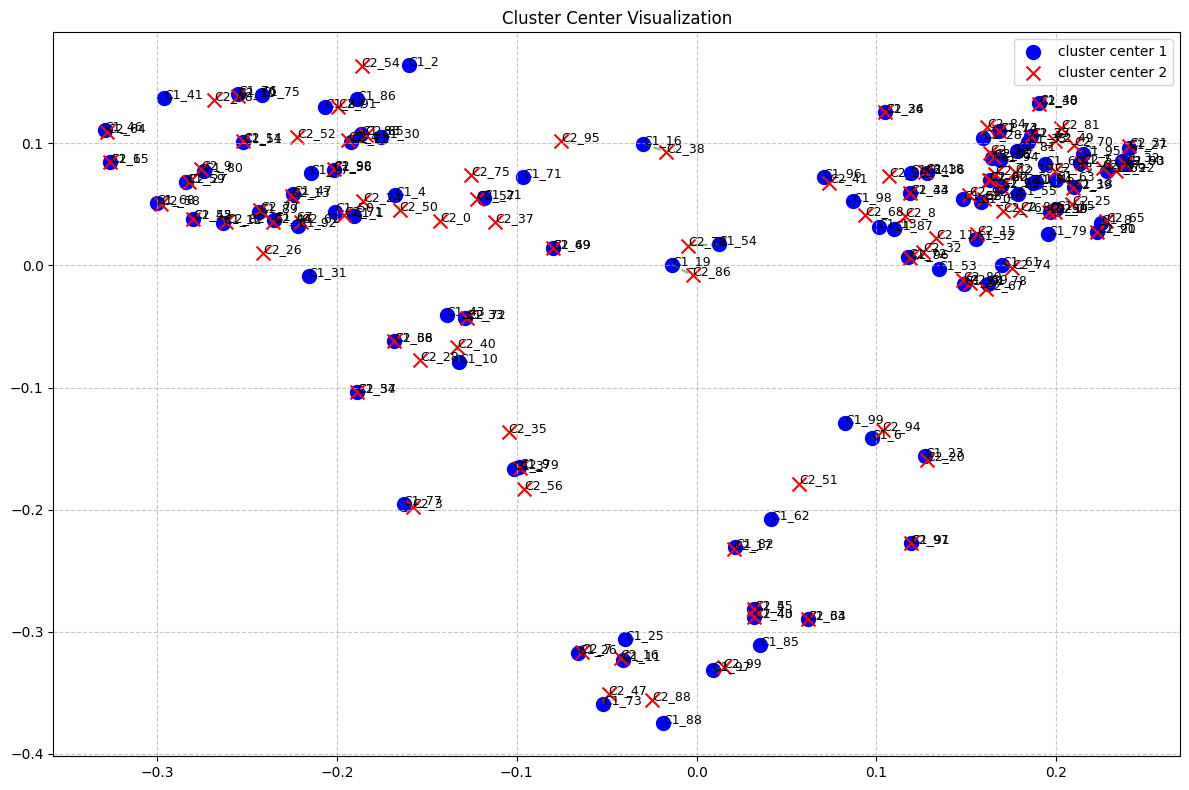

In [28]:
visualize_cluster_centers(
    cluster_centers1=centers1,
    cluster_centers2=centers2,
    mapping=valid_mapping,
    title="Cluster Center Visualization"
)